# Spectra acquisiton
Control both the stepping motor and the camera from this notebook.<br>
Make a loop to measure a wide-range spectrum automatically.

NOTE: only one connection to COM port is possible at a time. Shut down other connections, either in python or dedicated software.

In [1]:
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [2]:
import time, os, logging
from FLI import FLI
import numpy as np
import xarray as xr
from os.path import join

In [3]:
%run thr640.py
%run imaging_tool.py

In [4]:
logger = logger
logger.setLevel(50) # 10 - DEBUG 50 - CRITICAL 20 - INFO
camera = FLI()
step_motor = THR640() # Can only have one instance.

In [5]:
basepath = r'\\10.249.254.51\Public\Kuzmin\Experiments-Leprecon\Spectrometer\20221109'
# basepath = r'C:\Users\fujii\Documents\python\kuzmin\miura\20220629'
if not os.path.exists(basepath):
    os.makedirs(basepath)

# Single

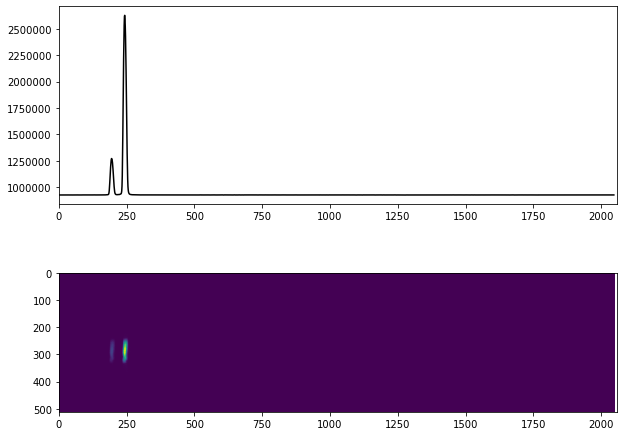

In [6]:
name=("test_Neon_withoutFilter_background")
name=("a")
exposure = 10 * 1e3 # ms
tag=""
# count=450000 # 615 nm
# count=740000 # 307.5 nm
# count=800000 # 226 nm
# count=100000 # 840 nm
# count=585000 # Hgamma
# count=635000 # Hbeta
# count=400000 # Halpha
# count=200000 # O2
# count=175000
count = 415000

step_motor.goto(count)
step_motor.waitUntilReady()
vbin = 1
attributes = {
    "temperature": camera.getTemperature(),
    "device_status": camera.getDeviceStatus(),
    "exposure": exposure,
    "frame_type": "light",
}
camera.setExposureTime(exposure);camera.setVBin(vbin);camera.setImageArea(10,0,2058,512//vbin);camera.exposeFrame()
time.sleep(.1)
# load image
image_data = camera.grabFrame(out=np.empty((512//vbin,2048), np.uint16))
# convert to xarray
data = xr.DataArray(
    image_data, dims=["y", "x"], coords={"image_counter": 0}, attrs=attributes
)
# save data as NetCDF file
filepath = join(basepath,f'{name}-{count}-{exposure}ms-{tag}.nc')
data.to_netcdf(filepath)
plot_image(image_data)


# LOOP

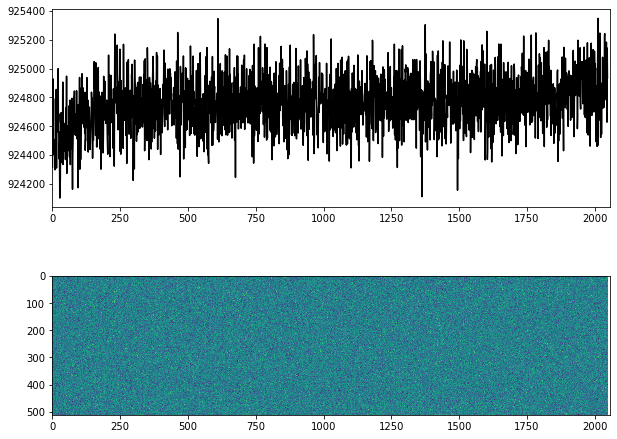

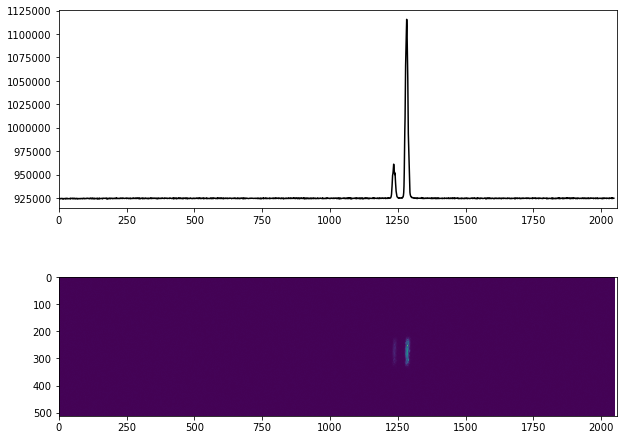

In [7]:
import datetime

name=("test_D_656filter_1227")
exposure = 1 * 1e3 # ms
tag=""
ampere = 0
R = range(200000,805000,5000)
R = [400000,410000,420000,430000,440000,450000]
R = [i for i in list(range(405000,415000,5000))]
# R = [390000,385000,380000,375000,370000,365000,360000,425000]
# R = [199000,200000,210000,390000,400000,410000,575000, 585000, 595000]
# R = [180000,185000,195000]
# R = [200000,400000,585000,635000]
# R = [415000,600000,650000]
# R = [420000]
T = [1 * 1e3]*len(R)
# T = [60e3]*9
# T = [60e3]*6
# T = [10e3]*4 #H2onlyloop
# T = [100e3,50e3,50e3,50e3] #H2O2loop
# T = [10e3]*100
hour=datetime.datetime.now().hour;minute=datetime.datetime.now().minute

for i in range(len(R)):
    step_motor.goto(R[i]);step_motor.waitUntilReady();vbin = 1
    attributes = {
        "temperature": camera.getTemperature(),
        "device_status": camera.getDeviceStatus(),
        "exposure": T[i],
        "frame_type": "light",
    }
    camera.setExposureTime(T[i]);camera.setVBin(vbin);camera.setImageArea(10,0,2058,512//vbin);camera.exposeFrame()
    time.sleep(.1)
    
    image_data = camera.grabFrame(out=np.empty((512//vbin,2048), np.uint16)) # load image
    data = xr.DataArray(image_data, dims=["y", "x"], coords={"image_counter": 0}, attrs=attributes) # convert to xarray
    plot_image(image_data)
    # filepath = join(basepath,f'{name}-{R[i]}-{T[i]}ms-{ampere}A-{tag}-{hour}{minute}.nc')
    filepath = join(basepath,f'{name}-{R[i]}-{T[i]}ms-{hour}{minute}-{tag}.nc')
    data.to_netcdf(filepath) # save data as NetCDF file